### DEMDP05 
# American Put Option Pricing Model

An American put option gives the holder the right, but not the obligation, to sell a specified quantity of a commodity at a specified strike price $K$ on or before a specified expiration period $T$. In the discrete time, continuous state Black-Scholes option pricing model, the price of the commodity follows an exogenous continuous-valued Markov process
\begin{equation}
    P_{t+1} = h(P_t, \epsilon_{t+1})
\end{equation}

**What is the value of an American put option in period $t$ if the commodity price is $P$?** At what critical price is it optimal to exercise the put option, and how does this critical price vary over time?

This is a finite horizon, stochastic model with time $t$ measured in periods. The state variables
\begin{align}
    P &\in (0,\infty) \\
    d &\in \{0, 1\}
\end{align}

are the current commodity price, a continuous variable, and the exercise status of the option, a discrete variable that equals 1 if the option has been exercised previously and equals 0 otherwise. The action variable
\begin{equation}
    j \in \{0, 1\}
\end{equation}    

is the exercise decision, a discrete variable that equals 1 if the option is exercised and equals 0 otherwise. The state transition function is
\begin{equation}
    g(P,d,j,\epsilon) = \left(h(P,\epsilon), j\right)
\end{equation}

The reward function is
\begin{equation}
    f(P,d,j) = \begin{cases}K − P, &d = 0, j = 1 \\
    0, &\text{otherwise} \end{cases}
\end{equation}    

The value of an unexercised option in period $t$, given that the commodity price is $P$, satisfies the Bellman equation
\begin{equation}
    V_t(P,0) = \max\left\{K − P, \quad\delta E_\epsilon V_{t+1}\left(h(P,\epsilon), 0\right)\right\}
\end{equation}

subject to the terminal condition $V_{T+1}(P,1) = 0$. The value of a previously exercised option is zero, regardless of the price of the commodity; that is, $V_t(P,1) = 0$ for all $P$ and $t$.

# Preliminary tasks

In [1]:
%matplotlib inline
from warnings import simplefilter
simplefilter('ignore')
from compecon import BasisSpline, NLP
from compecon.quad import qnwnorm
from demos.setup import np, plt, demo

## FORMULATION

In what follows, we are going to solve the problem in term of the log-price, defining $p\equiv\log(P)$. We assume that log-price of the commodity follows a random walk:
\begin{equation}
    p_{t+1} = p_t + \epsilon_{t+1}
\end{equation}

where $\epsilon$ is a normal $(\mu, \sigma^2)$ shock. We discretize this distribution by using ```qnwnorm```, assuming that $\mu=0.0001,\quad\sigma=0.008$ and setting up $m=15$ nodes.

In [2]:
mu, sigma    = 0.0001, 0.0080
m = 15
[e,w] = qnwnorm(m,mu,sigma ** 2)

We are going to compute the critical exercise price in terms of the time to expiration, up to an horizon of $T=300$ periods. First we allocate memory for the critical prices:

In [3]:
T = 300
pcrit = np.empty(T + 1)

The critical exercise price is the price at which the value of exercising the option $K-\exp(p)$ equals the discounted expected value of keeping the option one more period $\delta E_\epsilon V(p + \epsilon)$. To find it, we set it as a nonlinear rootfinding problem by using the ```NLP``` class; here we assume that the option strike price is $K=1$ and that the discount factor is $\delta=0.9998$

In [4]:
K = 1.0
delta = 0.9998
f = NLP(lambda p: K - np.exp(p) - delta * Value(p))

Notice that we have not defined the ```Value(p)``` function yet. This function is unknown, so we are going to approximate it with a cubic spline, setting 500 nodes between -1 and 1. Since the basis is expressed in terms of log-prices, this interval corresponds to prices between 0.3679 and 2.7183.

In [5]:
n = 500
pmin  = -1 # minimum log price
pmax  =  1 # maximum log price
Value = BasisSpline(n, pmin, pmax,
                    labels=['logprice'], l=['value'])
print(Value)

A 1-dimension Cubic spline basis:  using 500 Canonical nodes and 500 polynomials
___________________________________________________________________________
	logprice: 500 nodes in [ -1.00,   1.00]

WARNING! Class Basis is still work in progress


In the last expression, by passing the option `l` with a one-element list we are telling the ```BasisSpline``` class that we a single function named "value". On creation, the function will be set by default to $V(p)=0$ for all values of $p$, which conveniently corresponds to the terminal condition of this problem.

## Finding the critical exercise prices

We are going to find the prices recursively, starting form a option in the expiration date. Notice that the solution to this problem is trivial: since next-period value is zero, the exercise price is $K$. Either way, we can find it numerically by calling the ```zero``` method on the `f` object.

In [6]:
pcrit[0] = f.zero(0.0)

Next, for each possible price shock, we compute next period log-price by adding the shock to current log-prices (the nodes of the Value object). Then, we use each next-period price to compute the expected value of an option with one-period to maturity (save the values in ```v```). We update the value function to reflect the new time-to-maturity and use ```broyden``` to solve for the critical value. We repeat this procedure until we reach the $T=300$ horizon.

In [7]:
for t in range(T):
    v = np.zeros((1, n))
    for k in range(m):
        pnext = Value.nodes + e[k]
        v += w[k] * np.maximum(K - np.exp(pnext), delta * Value(pnext))

    Value[:] = v
    pcrit[t + 1] = f.broyden(pcrit[t])

### Print Critical Exercise Price 300 Periods to Expiration

In [8]:
print('Critical Price  = %5.2f' % np.exp(pcrit[-1]))

Critical Price  =  0.88


### Plot Critical Exercise Prices

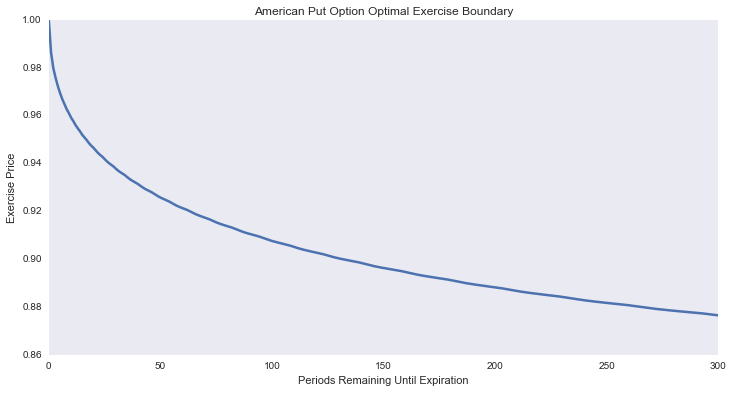

In [9]:
demo.figure('American Put Option Optimal Exercise Boundary',
            'Periods Remaining Until Expiration', 
            'Exercise Price')
plt.plot(np.exp(pcrit))
plt.show()